In [2]:
%matplotlib inline
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
train = np.loadtxt('train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('test.csv', delimiter=',', skiprows=1)

In [4]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]

# приводим размерность к удобному для обаботки виду
# добавляем размерность канала
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28, 1))
test_img = np.resize(test, (test.shape[0], 28, 28, 1))

## Визуализируем исходные данные

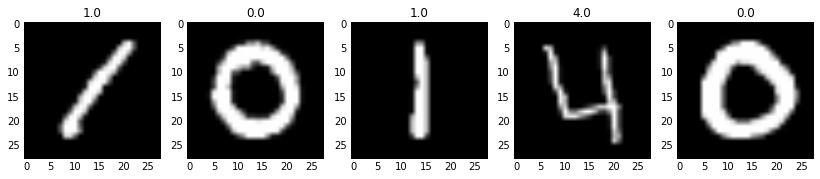

In [6]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5, :], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img[:,:,0], cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Готовим данные для полносвязной сети

In [7]:
#Нормализуем данные
X_train = train_img.reshape(len(train_img), 784)
X_test = test_img.reshape(len(test_img), 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train -= 127
X_test -= 127
X_train /= 255
X_test /= 255

from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, X_train, test_size=0.2, random_state=42)

from keras.utils import np_utils
y_train_labels = np_utils.to_categorical(y_train)
y_val_labels = np_utils.to_categorical(y_val)

In [8]:
x_train.shape

(33600, 784)

## Собираем и обучаем полносвязную сеть

In [9]:
# Создаем последовательную модель
model = keras.models.Sequential()

# Добавляем уровни сети
model.add(keras.layers.Dense(1600, input_dim=784, activation="relu", kernel_initializer="normal"))
model.add(keras.layers.Dense(800, activation='relu'))
model.add(keras.layers.Dense(90, activation='sigmoid'))
model.add(keras.layers.Dense(10, activation="softmax", kernel_initializer="normal"))

# Компилируем модель
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Обучаем сеть
model.fit(x_train, y_train_labels, batch_size=200, epochs=100, validation_data=(x_val, y_val_labels))

Train on 33600 samples, validate on 8400 samples
Epoch 1/100
33600/33600 [==============================] - 2s - loss: 0.6649 - acc: 0.8603 - val_loss: 0.2567 - val_acc: 0.9381
Epoch 2/100
33600/33600 [==============================] - 1s - loss: 0.1924 - acc: 0.9504 - val_loss: 0.1791 - val_acc: 0.9492
Epoch 3/100
33600/33600 [==============================] - 1s - loss: 0.1290 - acc: 0.9647 - val_loss: 0.1582 - val_acc: 0.9515
Epoch 4/100
33600/33600 [==============================] - 1s - loss: 0.0968 - acc: 0.9729 - val_loss: 0.1186 - val_acc: 0.9668
Epoch 5/100
33600/33600 [==============================] - 1s - loss: 0.0791 - acc: 0.9776 - val_loss: 0.1100 - val_acc: 0.9665
Epoch 6/100
33600/33600 [==============================] - 1s - loss: 0.0606 - acc: 0.9829 - val_loss: 0.1001 - val_acc: 0.9705
Epoch 7/100
33600/33600 [==============================] - 1s - loss: 0.0523 - acc: 0.9852 - val_loss: 0.0943 - val_acc: 0.9726
Epoch 8/100
33600/33600 [==============================

In [10]:
pred_val = model.predict_classes(x_val, verbose=0)
from sklearn.metrics import accuracy_score
rate = accuracy_score(y_val, pred_val)
print('Accuracy: %s' % rate)
rates = [rate]

Accuracy: 0.9825


In [11]:
models = [model]

In [12]:
tests = [X_test]

# Считаем гистограммы градиентов

### Можно следующие блоки пропустить и сразу перейти к загрузке сохранённых гистограмм из файлов

In [141]:
import cv2
# приводим размерность к удобному для обаботки виду
train_img_for_hist = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img_for_hist = np.resize(test, (test.shape[0], 28, 28))

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [144]:
train_sobel_x = np.zeros_like(train_img_for_hist)
train_sobel_y = np.zeros_like(train_img_for_hist)
for i in range(len(train_img_for_hist)):
    train_sobel_x[i] = cv2.Sobel(train_img_for_hist[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img_for_hist[i], cv2.CV_64F, dx=0, dy=1, ksize=3)
test_sobel_x = np.zeros_like(test_img_for_hist)
test_sobel_y = np.zeros_like(test_img_for_hist)
for i in range(len(test_img_for_hist)):
    test_sobel_x[i] = cv2.Sobel(test_img_for_hist[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img_for_hist[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [ ]:
bins = 16

In [ ]:
 def describe(sobel_x, sobel_y):
        """ Вычисляем дескриптор изображения """
        
        features = []  # результирующий вектор дескриптора
        
 
        (h, w) = sobel_x.shape[0], sobel_x.shape[1]  # размеры изображения
        (cX, cY) = (int(w * 0.5), int(h * 0.5))  # координаты центра изображения
        
        # делим изображение на четыре равные части
        # и вычисляем координаты сегментов
        segments = [(0, cX, 0, cY), 
                    (cX, w, 0, cY),
                    (cX, w, cY, h),
                    (0, cX, cY, h),
                    (int(0.25*w), int(0.75*w), cY, h),
                    (int(0.25*w), int(0.75*w), 0, cY)]
 
        # готовим маску в виде эллипса для выделения 
        # дескрипторов центральной части изображения
        (axesX, axesY) = (int(w * 0.5) // 2, int(h * 0.5) // 2)
        ellip_mask = np.zeros(sobel_x.shape[:2], dtype = np.uint8)
        cv2.ellipse(ellip_mask, (cX, cY), (axesX, axesY), 0, 0, 360, 255, -1)
 
        # итерируем по сегментам и вычисляем дескрипторы
        for (startX, endX, startY, endY) in segments:
            # формируем маску сегмента
            corner_mask = np.zeros(sobel_x.shape[:2], dtype = np.uint8)
            cv2.rectangle(corner_mask, (startX, startY), (endX, endY), 255, -1)
 
            # строим гистограмму градиентов с учетом маски сегмента
            hist = histogram(sobel_x, sobel_y, corner_mask)
            features.extend(hist)
 
        # вычисляем гистограму для центральной области
        hist = histogram(sobel_x, sobel_y, ellip_mask)
        features.extend(hist)
 
        # возвращаем вектор полученный вектор дескрипторов
        return features

In [ ]:
def histogram(sobel_x, sobel_y, mask):
        """ Вычисляет гистограмму в области, заданной маской """
        sob_x = np.zeros_like(sobel_x)
        sob_y = np.zeros_like(sobel_y)
        np.copyto(sob_x, sobel_x)
        np.copyto(sob_y, sobel_y)
        sob_x[mask == 0] = 0
        sob_y[mask == 0] = 0
        
        g, theta = cv2.cartToPolar(sob_x, sob_y)
        
        final_hist = np.zeros((len(train_img), bins))
        hist, _ = np.histogram(theta,
                                 bins=bins,
                                 range=(0., 2. * np.pi),
                                 weights=g)
        return hist

## Вычисляем гистограммы градиентов

In [ ]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), bins*7))
for i in range(len(train_img)):
    hist = describe(train_sobel_x[i], train_sobel_y[i])
    train_hist[i] = hist
np.savetxt("train_hst.csv", train_hist, delimiter=",")
# Гистограммы вычисляются с учетом длины вектора градиента
test_hist = np.zeros((len(test_img), bins*7))
for i in range(len(test_img)):
    hist = describe(test_sobel_x[i], test_sobel_y[i])
    test_hist[i] = hist
np.savetxt("test_hst.csv", test_hist, delimiter=",")

# Загружаем гистограммы из файлов

In [13]:
train_hist = np.loadtxt('train_hst.csv', delimiter=',')
test_hist = np.loadtxt('test_hst.csv', delimiter=',')

## Нормируем вектор гистограммы 

In [14]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Хитрым образом отбираем данные для обучения и валидации

In [15]:
TRAIN_PART = 0.8
predictions = []
predict = models[0].predict_classes(X_train, verbose=0)
predictions.append(predict)

train_indexes_ = []

other_indexes_ = []
for i in range(0, len(predict)):
    if predict[i] != train_label[i]:
        train_indexes_.append(i)
    else:
        other_indexes_.append(i)
import random
random.shuffle(other_indexes_)

indexes = train_indexes_ + other_indexes_
border = int(TRAIN_PART*len(indexes))
train_indexes = indexes[:border]
val_indexes = indexes[border:]

x_train = []
y_train = []
x_val = []
y_val = []
for i in train_indexes:
    x_train.append(train_hist[i])
    y_train.append(train_label[i])

for i in val_indexes:
    x_val.append(train_hist[i])
    y_val.append(train_label[i])

x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)

## Собираем полносвязную сеть для обучения на гистограммах

In [16]:
np.random.seed(42)
model = keras.models.Sequential()
model.add(keras.layers.Dense(1600, input_dim=x_train.shape[1], activation='relu'))
model.add(keras.layers.Dense(1000, activation='relu'))
model.add(keras.layers.Dense(90, activation='sigmoid'))
model.add(keras.layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()
from keras.utils import np_utils
y_train_labels = np_utils.to_categorical(y_train)
y_val_labels = np_utils.to_categorical(y_val)
model.fit(x_train, y_train_labels, batch_size=300, epochs=45, shuffle=True, validation_data=(x_val, y_val_labels))
pred_val = model.predict_classes(x_val)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1600)              180800    
_________________________________________________________________
dense_6 (Dense)              (None, 1000)              1601000   
_________________________________________________________________
dense_7 (Dense)              (None, 90)                90090     
_________________________________________________________________
dense_8 (Dense)              (None, 10)                910       
Total params: 1,872,800
Trainable params: 1,872,800
Non-trainable params: 0
_________________________________________________________________
Train on 33600 samples, validate on 8400 samples
Epoch 1/45
33600/33600 [==============================] - 1s - loss: 0.8103 - acc: 0.7723 - val_loss: 0.2653 - val_acc: 0.9288
Epoch 2/45
33600/33600 [==============================] - 1s - loss: 0.2015 - acc: 0.944

In [17]:
pred_val = model.predict_classes(x_val, verbose=0)
from sklearn.metrics import accuracy_score
rate = accuracy_score(y_val, pred_val)
print('Accuracy: %s' % rate)
rates.append(rate)

Accuracy: 0.981785714286


In [18]:
models.append(model)

In [19]:
tests.append(test_hist)

# Свёрточная нейронная сеть

## Хитрым образом отбираем данные для обучения и валидации

In [20]:
predict = models[1].predict_classes(train_hist, verbose=0)
predictions.append(predict)

train_indexes_ = []
other_indexes_ = []
for i in range(0, len(predict)):
    if predict[i] != train_label[i] or predictions[0][i] != train_label[i]:
        train_indexes_.append(i)
    else:
        other_indexes_.append(i)
import random
random.shuffle(other_indexes_)

indexes = train_indexes_ + other_indexes_
border = int(TRAIN_PART*len(indexes))
train_indexes = indexes[:border]
val_indexes = indexes[border:]

x_train = []
y_train = []
x_val = []
y_val = []
for i in train_indexes:
    x_train.append(train_img[i])
    y_train.append(train_label[i])

for i in val_indexes:
    x_val.append(train_img[i])
    y_val.append(train_label[i])

x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)

## Собираем сверточную сеть для обучения

In [21]:
kern_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=42)

In [22]:
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(6, 
                              kernel_size=(5, 5), 
                              padding='same', 
                              activation='relu', 
                              input_shape=x_train.shape[1:], kernel_initializer=kern_init, bias_initializer=kern_init))

model.add(keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'))


model.add(keras.layers.Conv2D(16, 
                              kernel_size=(5, 5),
                              padding='valid',
                              activation='relu', kernel_initializer=kern_init, bias_initializer=kern_init))

model.add(keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'))

model.add(keras.layers.Conv2D(120, 
                              kernel_size=(5, 5),
                              padding='valid',
                              activation='relu', kernel_initializer=kern_init, bias_initializer=kern_init))

model.add(keras.layers.Flatten())

model.add(keras.layers.normalization.BatchNormalization())

model.add(keras.layers.Dense(84, activation='tanh', kernel_initializer=kern_init, bias_initializer=kern_init))

model.add(keras.layers.Dense(10, activation='softmax', kernel_initializer=kern_init, bias_initializer=kern_init))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## One hot encoding разметки

In [23]:
from keras.utils import np_utils
y_train_labels = np_utils.to_categorical(y_train)
y_val_labels = np_utils.to_categorical(y_val)

## Запускаем обучение

In [24]:
#np.random.seed(42)
model.fit(x_train, y_train_labels, batch_size=300, epochs=50, validation_data=(x_val, y_val_labels))

Train on 33600 samples, validate on 8400 samples
Epoch 1/50
33600/33600 [==============================] - 5s - loss: 0.5476 - acc: 0.8917 - val_loss: 0.1125 - val_acc: 0.9755
Epoch 2/50
33600/33600 [==============================] - 1s - loss: 0.0852 - acc: 0.9791 - val_loss: 0.0781 - val_acc: 0.9775
Epoch 3/50
33600/33600 [==============================] - 1s - loss: 0.0518 - acc: 0.9864 - val_loss: 0.0572 - val_acc: 0.9845
Epoch 4/50
33600/33600 [==============================] - 1s - loss: 0.0369 - acc: 0.9893 - val_loss: 0.0501 - val_acc: 0.9848
Epoch 5/50
33600/33600 [==============================] - 1s - loss: 0.0285 - acc: 0.9923 - val_loss: 0.0436 - val_acc: 0.9869
Epoch 6/50
33600/33600 [==============================] - 1s - loss: 0.0220 - acc: 0.9939 - val_loss: 0.0398 - val_acc: 0.9876
Epoch 7/50
33600/33600 [==============================] - 1s - loss: 0.0166 - acc: 0.9955 - val_loss: 0.0421 - val_acc: 0.9861
Epoch 8/50
33600/33600 [==============================] - 1s -

## Оцениваем качество решение на валидационной выборке

In [25]:
pred_val = model.predict_classes(x_val, verbose=0)
from sklearn.metrics import accuracy_score
rate = accuracy_score(y_val, pred_val)
print('Accuracy: %s' % rate)
rates.append(rate)

Accuracy: 0.99130952381


In [26]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00       844
        1.0       1.00      1.00      1.00       908
        2.0       0.99      0.99      0.99       804
        3.0       0.99      0.99      0.99       891
        4.0       0.99      0.99      0.99       840
        5.0       0.99      0.99      0.99       737
        6.0       0.99      0.99      0.99       862
        7.0       0.99      0.99      0.99       909
        8.0       0.99      1.00      0.99       806
        9.0       0.99      0.98      0.99       799

avg / total       0.99      0.99      0.99      8400



In [27]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[840   0   1   0   0   2   0   0   1   0]
 [  0 904   0   1   0   0   0   3   0   0]
 [  1   1 799   1   0   0   1   1   0   0]
 [  0   0   3 883   0   2   0   0   3   0]
 [  0   1   0   0 830   0   1   2   1   5]
 [  1   0   0   1   0 729   4   2   0   0]
 [  2   0   2   0   2   5 851   0   0   0]
 [  0   0   5   0   0   0   0 902   1   1]
 [  0   0   0   0   0   1   1   0 802   2]
 [  0   0   0   2   6   1   0   1   2 787]]


In [28]:
models.append(model)

In [29]:
tests.append(test_img)

# Голосование 3-х сетей

In [31]:
def predict():
    global predictions_3
    predictions_3 = []
    prediction = np.zeros(len(tests[0]), dtype=int)
    for i in range(0, len(models)):
        predictions_3.append(models[i].predict_classes(tests[i], verbose=False))
    for j in range(0, len(prediction)):
        d ={}
        for i in range(0,len(predictions_3)):
            try:
                d[predictions_3[i][j]] = d[predictions_3[i][j]] + rates[i]
            except KeyError:
                d[predictions_3[i][j]] = rates[i]
        prediction[j] = max(d, key=d.get)
        if (len(d)!=1):
            print(j, d)  # При расхождении разультатов - вывод
    return prediction

## Предсказания на тестовыйх данных

In [32]:
pred_test = predict()

3 {0: 0.99130952380952386, 9: 1.9642857142857144}
48 {0: 0.98178571428571426, 6: 1.9738095238095239}
59 {0: 1.9642857142857144, 9: 0.99130952380952386}
76 {9: 1.973095238095238, 5: 0.98250000000000004}
81 {9: 0.98250000000000004, 4: 1.973095238095238}
157 {3: 0.98250000000000004, 5: 1.973095238095238}
165 {2: 1.9642857142857144, 3: 0.99130952380952386}
275 {8: 0.99130952380952386, 9: 0.98250000000000004, 5: 0.98178571428571426}
341 {9: 0.99130952380952386, 2: 0.98250000000000004, 3: 0.98178571428571426}
359 {9: 0.98178571428571426, 7: 1.9738095238095239}
450 {9: 0.98178571428571426, 5: 1.9738095238095239}
460 {1: 0.98178571428571426, 6: 1.9738095238095239}
511 {5: 1.9738095238095239, 6: 0.98178571428571426}
520 {4: 0.98178571428571426, 6: 1.9738095238095239}
538 {4: 0.98178571428571426, 7: 1.9738095238095239}
554 {0: 1.9738095238095239, 5: 0.98178571428571426}
626 {8: 1.973095238095238, 9: 0.98250000000000004}
640 {0: 1.9642857142857144, 2: 0.99130952380952386}
645 {2: 0.99130952380952

16281 {5: 1.9738095238095239, 6: 0.98178571428571426}
16323 {0: 0.98178571428571426, 2: 0.99130952380952386, 5: 0.98250000000000004}
16327 {9: 1.973095238095238, 7: 0.98250000000000004}
16354 {8: 1.9738095238095239, 3: 0.98178571428571426}
16365 {5: 0.98250000000000004, 6: 1.973095238095238}
16396 {8: 1.973095238095238, 3: 0.98250000000000004}
16434 {9: 1.973095238095238, 4: 0.98250000000000004}
16447 {8: 0.98250000000000004, 9: 1.973095238095238}
16448 {2: 1.9738095238095239, 3: 0.98178571428571426}
16452 {8: 0.99130952380952386, 9: 0.98250000000000004, 4: 0.98178571428571426}
16475 {8: 1.973095238095238, 1: 0.98250000000000004}
16490 {1: 1.9738095238095239, 7: 0.98178571428571426}
16518 {1: 0.99130952380952386, 2: 1.9642857142857144}
16522 {4: 0.98250000000000004, 5: 1.973095238095238}
16544 {5: 0.98178571428571426, 7: 1.9738095238095239}
16555 {8: 1.973095238095238, 6: 0.98250000000000004}
16577 {8: 1.973095238095238, 3: 0.98250000000000004}
16608 {9: 1.973095238095238, 4: 0.9825000

## Визуализируем предсказания

3
[9 3 7 0 3]
[9 3 7 0 3]
[0 3 7 0 3]


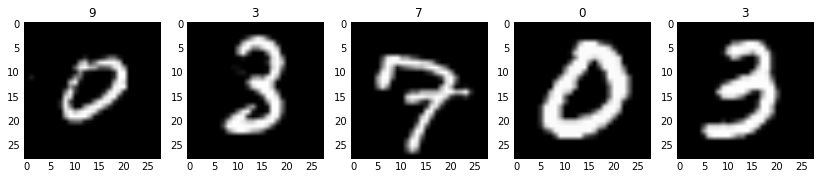

In [35]:
# a - номер интересующего изображения
a = 3 # int(np.random.sample(1)*20000)
fig = plt.figure(figsize=(20, 10))
print(a)
for i, img in enumerate(test_img[0+a:5+a], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img[:,:,0], cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1+a]);
for k in range(0, 3):
    print(predictions_3[k][0+a:5+a])

## Готовим файл для отправки

In [239]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test3, 1):
        dst.write('%s,%s\n' % (i, p))

In [ ]:
# Your submission scored 0.99228